In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
def f(x):
    return 3*x**2-4*x+5

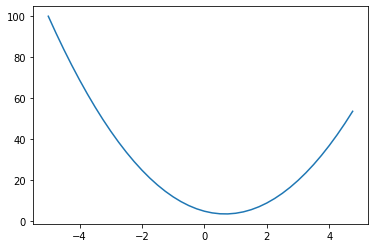

In [54]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [5]:
# derivative at 2/3
h=0.001
x=2/3
(f(x+h)-f(x))/h

0.0029999999995311555

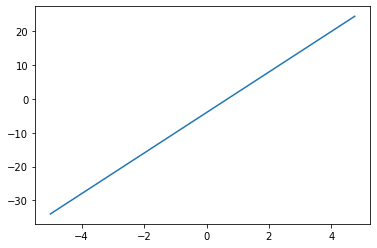

In [6]:
def d():
    ds=[]
    h=0.001
    for i in range(len(ys)):
        ds.append((f(xs[i]+h)-f(xs[i]))/h)
    return ds
ds=d()
plt.plot(xs,ds)

In [7]:
a=2.0
b=-3.0
c=10.0

d1=a*b+c
a+=h
d2=a*b+c

print(f"d1 {d1}")
print(f"d2 {d2}")
print(f"slope",(d2-d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [8]:
class Value:
    def __init__(self,data,_children=(),_op='',label=""):
        self.data=data
        self.grad=0.0
        self._prev=set(_children)
        self._op=_op
        self.label=label
    def __repr__(self):
        return (f"Value(data)={self.data}")
    def __add__(self,other):
        out = Value(self.data+other.data,(self,other),_op="+")
        return out
    def __sub__(self,other):
        out = Value(self.data-other.data,(self,other),_op="-")
        return out
    def __div__(self,other):
        out = Value(self.data/other.data,(self,other),_op="/")
        return out
    def __mul__(self,other):
        out = Value(self.data*other.data,(self,other),_op="*")
        return out

In [10]:
a=Value(2.1,label="a")
b=Value(5,label="b")
c=Value(10,label="c")
d=a*b+c
d._prev

{Value(data)=10, Value(data)=10.5}

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



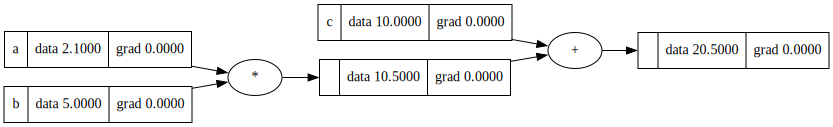

In [23]:
# download link for graphwiz on windows: https://graphviz.org/download

import os
os.environ["PATH"] += os.pathsep + 'F:\\softwares\\Graphviz\\bin'
draw_dot(d)

In [43]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L



Value(data)=-8.0

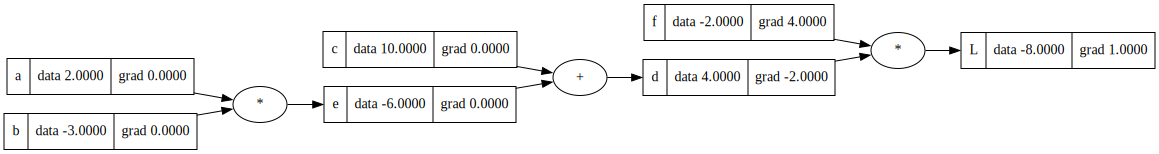

In [50]:
draw_dot(L)

In [47]:
# Manual Backprop
"""

From mulitvar caluclus

dl/dd=f
dl/df=d

dd/de=d
dd/dc=d

da/de=b
db/de=a



dl/dc=

"""
# L.grad=1
# d.grad=f.data
# f.grad=d.data

# e.grad=d.data
# c.grad=d.data

In [38]:
def backProp():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

    L1=L.data
    h=.0001
    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2=L.data
    print((L2-L1)/h)
backProp()


-4.000000000008441
